## <center>Курсовой проект <a class="anchor" id="course_project"></a><center>

**Содержание**

* [Введение](#theory)
* [Обзор данных](#course_project_review)
* [Подготовка модели](#make_model)
* [Применение модели](#practice)

## Введение<a class="anchor" id="theory"></a>

**Задача**

Требуется, на основании имеющихся данных о клиентах банка, построить модель, используя обучающий датасет, для прогнозирования невыполнения долговых обязательств по текущему кредиту. Выполнить прогноз для примеров из тестового датасета.

**Наименование файлов с данными**

course_project_train.csv - обучающий датасет<br>
course_project_test.csv - тестовый датасет

**Целевая переменная**

Credit Default - факт невыполнения кредитных обязательств

**Метрика качества**

F1-score (sklearn.metrics.f1_score)

**Требования к решению**

*Целевая метрика*
* F1 > 0.5
* Метрика оценивается по качеству прогноза для главного класса (1 - просрочка по кредиту)


In [63]:
import pandas as pd
import numpy as np
import pickle
import random

import missingno as msno
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [64]:
from scipy.stats import randint
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV

In [65]:
from scipy.stats import shapiro
from scipy.stats import probplot
from scipy.stats import ttest_ind, mannwhitneyu
from scipy.stats import chi2_contingency
from statsmodels.stats.weightstats import zconfint

In [66]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [67]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb, lightgbm as lgbm, catboost as catb

In [68]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from catboost import Pool, CatBoostClassifier, EFstrType
from sklearn.neighbors import KNeighborsClassifier

import xgboost as xgb, lightgbm as lgbm, catboost as catb
from collections import Counter
from scipy.stats import randint,uniform

In [69]:
from imblearn.datasets import make_imbalance
from sklearn.datasets import make_classification
from imblearn.over_sampling import RandomOverSampler

In [70]:
import warnings
warnings.filterwarnings('ignore')

In [71]:
# !pip install xgboost
# !pip install lightgbm
# !pip install catboost

In [72]:
#!jupyter nbextension enable --py widgetsnbextension --user


In [73]:
#pip install ipywidgets

### Обзор данных<a class="anchor" id="course_project_review"></a>

In [74]:
# input
TRAIN_PATH = '/home/mikhail/Рабочий стол/DS_02/course_project/course_project_train.csv'
TEST_PATH = '/home/mikhail/Рабочий стол/DS_02/course_project/course_project_test.csv'

SCALER_FILE_PATH = '/home/mikhail/Рабочий стол/DS_02/scaler.pkl'

MODEL_FILE_PATH = '/home/mikhail/Рабочий стол/DS_02/model_02.pkl'

In [75]:
df_train = pd.read_csv(TRAIN_PATH)
df_train

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7495,Rent,402192.0,< 1 year,0.0,3.0,8.5,107866.0,0.0,NaN,0.0,other,Short Term,129360.0,73492.0,1900.0,697.0,0
7496,Home Mortgage,1533984.0,1 year,0.0,10.0,26.5,686312.0,0.0,43.0,0.0,debt consolidation,Long Term,444048.0,456399.0,12783.0,7410.0,1
7497,Rent,1878910.0,6 years,0.0,12.0,32.1,1778920.0,0.0,NaN,0.0,buy a car,Short Term,99999999.0,477812.0,12479.0,748.0,0
7498,Home Mortgage,NaN,NaN,0.0,21.0,26.5,1141250.0,0.0,NaN,0.0,debt consolidation,Short Term,615274.0,476064.0,37118.0,NaN,0


**Описание датасета**

* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые обременения
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

In [76]:
def view_matrix(df_train):
    
    '''показывает пропуски по колонкам и общую информацию о сете'''
    for colname in df_train.select_dtypes(include='object').columns:
        print(str(colname) + '\n\n' + str(df_train[colname].value_counts()) + '\n' + '*' * 100 + '\n')
    
    msno.matrix(df_train) 
    display("/usr/local/share/datasets/matrix_sorted.png")
    
    print(df_train.head())
    print(len(df_train) - df_train.count(), df_train.info())

Home Ownership

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64
****************************************************************************************************

Years in current job

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64
****************************************************************************************************

Purpose

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation  

'/usr/local/share/datasets/matrix_sorted.png'

  Home Ownership  Annual Income Years in current job  Tax Liens  \
0       Own Home       482087.0                  NaN        0.0   
1       Own Home      1025487.0            10+ years        0.0   
2  Home Mortgage       751412.0              8 years        0.0   
3       Own Home       805068.0              6 years        0.0   
4           Rent       776264.0              8 years        0.0   

   Number of Open Accounts  Years of Credit History  Maximum Open Credit  \
0                     11.0                     26.3             685960.0   
1                     15.0                     15.3            1181730.0   
2                     11.0                     35.0            1182434.0   
3                      8.0                     22.5             147400.0   
4                     13.0                     13.6             385836.0   

   Number of Credit Problems  Months since last delinquent  Bankruptcies  \
0                        1.0                           NaN      

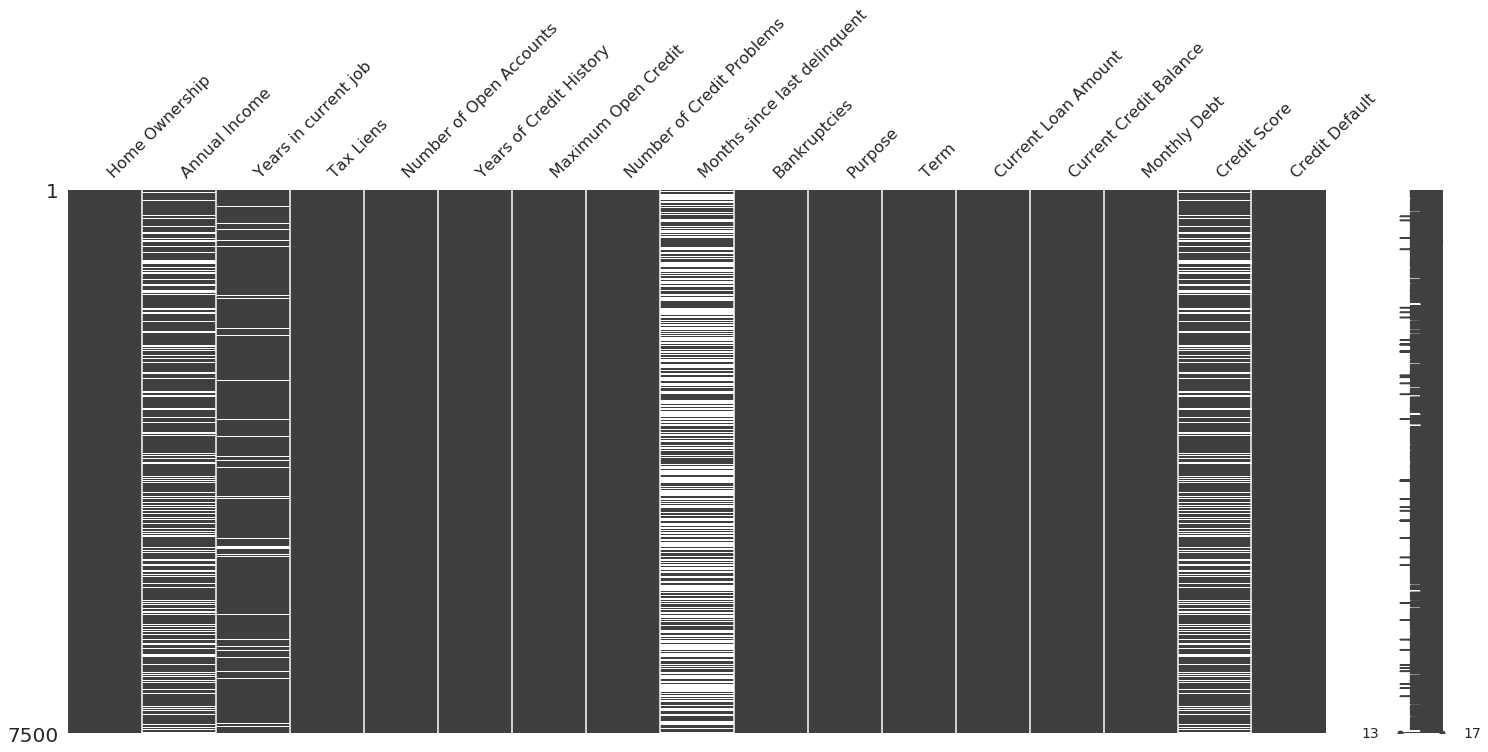

In [77]:
view_matrix(df_train)

**Обработка датасета**

Общий подход 
*  перевести объекты в нумерический вид присвоив им метки 
*  заполнить пропущенные значения 

In [78]:
from sklearn.preprocessing import LabelEncoder

In [79]:
def prepare_label(df_train):
    '''функция преобразующая строковые объекты в метки'''
    
    le = LabelEncoder()

    for col in df_train.columns:       
        if df_train[col].dtypes=='object':
            df_train[col]=le.fit_transform(df_train[col].astype(str))
    return df_train        

In [80]:
prepare_label(df_train)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,2,482087.0,11,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,3,1,99999999.0,47386.0,7914.0,749.0,0
1,2,1025487.0,1,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,3,0,264968.0,394972.0,18373.0,737.0,1
2,1,751412.0,8,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,3,1,99999999.0,308389.0,13651.0,742.0,0
3,2,805068.0,6,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,3,1,121396.0,95855.0,11338.0,694.0,0
4,3,776264.0,8,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,3,1,125840.0,93309.0,7180.0,719.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7495,3,402192.0,10,0.0,3.0,8.5,107866.0,0.0,NaN,0.0,9,1,129360.0,73492.0,1900.0,697.0,0
7496,1,1533984.0,0,0.0,10.0,26.5,686312.0,0.0,43.0,0.0,3,0,444048.0,456399.0,12783.0,7410.0,1
7497,3,1878910.0,6,0.0,12.0,32.1,1778920.0,0.0,NaN,0.0,1,1,99999999.0,477812.0,12479.0,748.0,0
7498,1,NaN,11,0.0,21.0,26.5,1141250.0,0.0,NaN,0.0,3,1,615274.0,476064.0,37118.0,NaN,0


In [81]:
# библиотека для заполнения пропусков
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [82]:
def missing_imputer(df_train):
    '''функция заполняющая пробелы'''
    
    numeric_cols = df_train.select_dtypes(include=[np.number])

    imp_iter = IterativeImputer(n_nearest_features=4,max_iter=10, sample_posterior=True, random_state=123)
    df_train = imp_iter.fit_transform(numeric_cols)
 
    df_train = pd.DataFrame(df_train, columns=numeric_cols.columns)
    
    return df_train  

In [83]:
df_train=missing_imputer(df_train)
df_train

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,2.0,4.820870e+05,11.0,0.0,11.0,26.3,685960.0,1.0,39.842803,1.0,3.0,1.0,99999999.0,47386.0,7914.0,749.000000,0.0
1,2.0,1.025487e+06,1.0,0.0,15.0,15.3,1181730.0,0.0,24.730240,0.0,3.0,0.0,264968.0,394972.0,18373.0,737.000000,1.0
2,1.0,7.514120e+05,8.0,0.0,11.0,35.0,1182434.0,0.0,20.013996,0.0,3.0,1.0,99999999.0,308389.0,13651.0,742.000000,0.0
3,2.0,8.050680e+05,6.0,0.0,8.0,22.5,147400.0,1.0,36.408613,1.0,3.0,1.0,121396.0,95855.0,11338.0,694.000000,0.0
4,3.0,7.762640e+05,8.0,0.0,13.0,13.6,385836.0,1.0,-12.639178,0.0,3.0,1.0,125840.0,93309.0,7180.0,719.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7495,3.0,4.021920e+05,10.0,0.0,3.0,8.5,107866.0,0.0,31.707424,0.0,9.0,1.0,129360.0,73492.0,1900.0,697.000000,0.0
7496,1.0,1.533984e+06,0.0,0.0,10.0,26.5,686312.0,0.0,43.000000,0.0,3.0,0.0,444048.0,456399.0,12783.0,7410.000000,1.0
7497,3.0,1.878910e+06,6.0,0.0,12.0,32.1,1778920.0,0.0,34.880427,0.0,1.0,1.0,99999999.0,477812.0,12479.0,748.000000,0.0
7498,1.0,2.832489e+06,11.0,0.0,21.0,26.5,1141250.0,0.0,33.853861,0.0,3.0,1.0,615274.0,476064.0,37118.0,914.955393,0.0


In [84]:
def prepare_missing_n_label(df_train):
    
    ''' сборная функция присваивающая метки и обрабатывающая пропуски '''
    
    prepare_label(df_train)
    missing_imputer(df_train)
    
    return df_train


In [85]:
# Итоговый датасет
df_train=prepare_missing_n_label(df_train)

* Проверка обработанных данных

'/usr/local/share/datasets/matrix_sorted.png'

   Home Ownership  Annual Income  Years in current job  Tax Liens  \
0             2.0       482087.0                  11.0        0.0   
1             2.0      1025487.0                   1.0        0.0   
2             1.0       751412.0                   8.0        0.0   
3             2.0       805068.0                   6.0        0.0   
4             3.0       776264.0                   8.0        0.0   

   Number of Open Accounts  Years of Credit History  Maximum Open Credit  \
0                     11.0                     26.3             685960.0   
1                     15.0                     15.3            1181730.0   
2                     11.0                     35.0            1182434.0   
3                      8.0                     22.5             147400.0   
4                     13.0                     13.6             385836.0   

   Number of Credit Problems  Months since last delinquent  Bankruptcies  \
0                        1.0                     39.

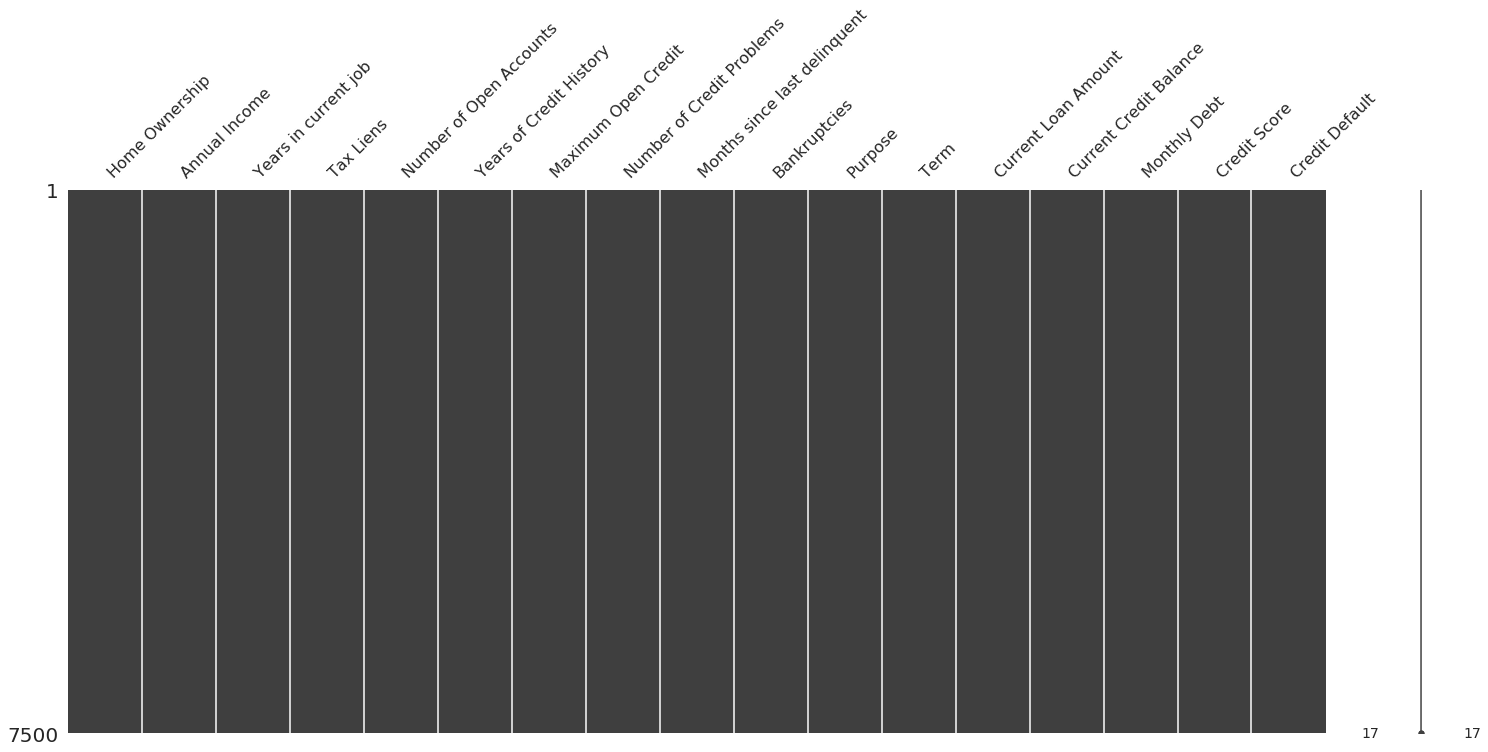

In [86]:
view_matrix(df_train)

*Наши данные готовы к более подробному рассмотрению*

**Рассмотрим как данные связаны с нашим целевым значением**

In [87]:

TARGET_NAME = 'Credit Default'
BASE_FEATURE_NAMES = df_train.columns.drop(TARGET_NAME).tolist()

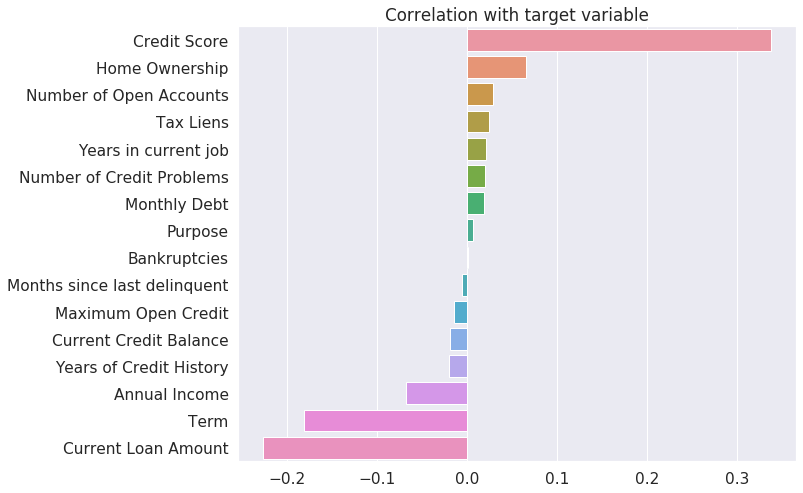

In [88]:
corr_with_target = df_train[BASE_FEATURE_NAMES + [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

In [89]:
correlations_data = df_train.corr()[TARGET_NAME].sort_values()
correlations_data 

Current Loan Amount            -0.226522
Term                           -0.181487
Annual Income                  -0.068526
Years of Credit History        -0.020567
Current Credit Balance         -0.019522
Maximum Open Credit            -0.014275
Months since last delinquent   -0.005930
Bankruptcies                    0.001045
Purpose                         0.005841
Monthly Debt                    0.018480
Number of Credit Problems       0.020088
Years in current job            0.020398
Tax Liens                       0.024368
Number of Open Accounts         0.028884
Home Ownership                  0.065620
Credit Score                    0.337122
Credit Default                  1.000000
Name: Credit Default, dtype: float64

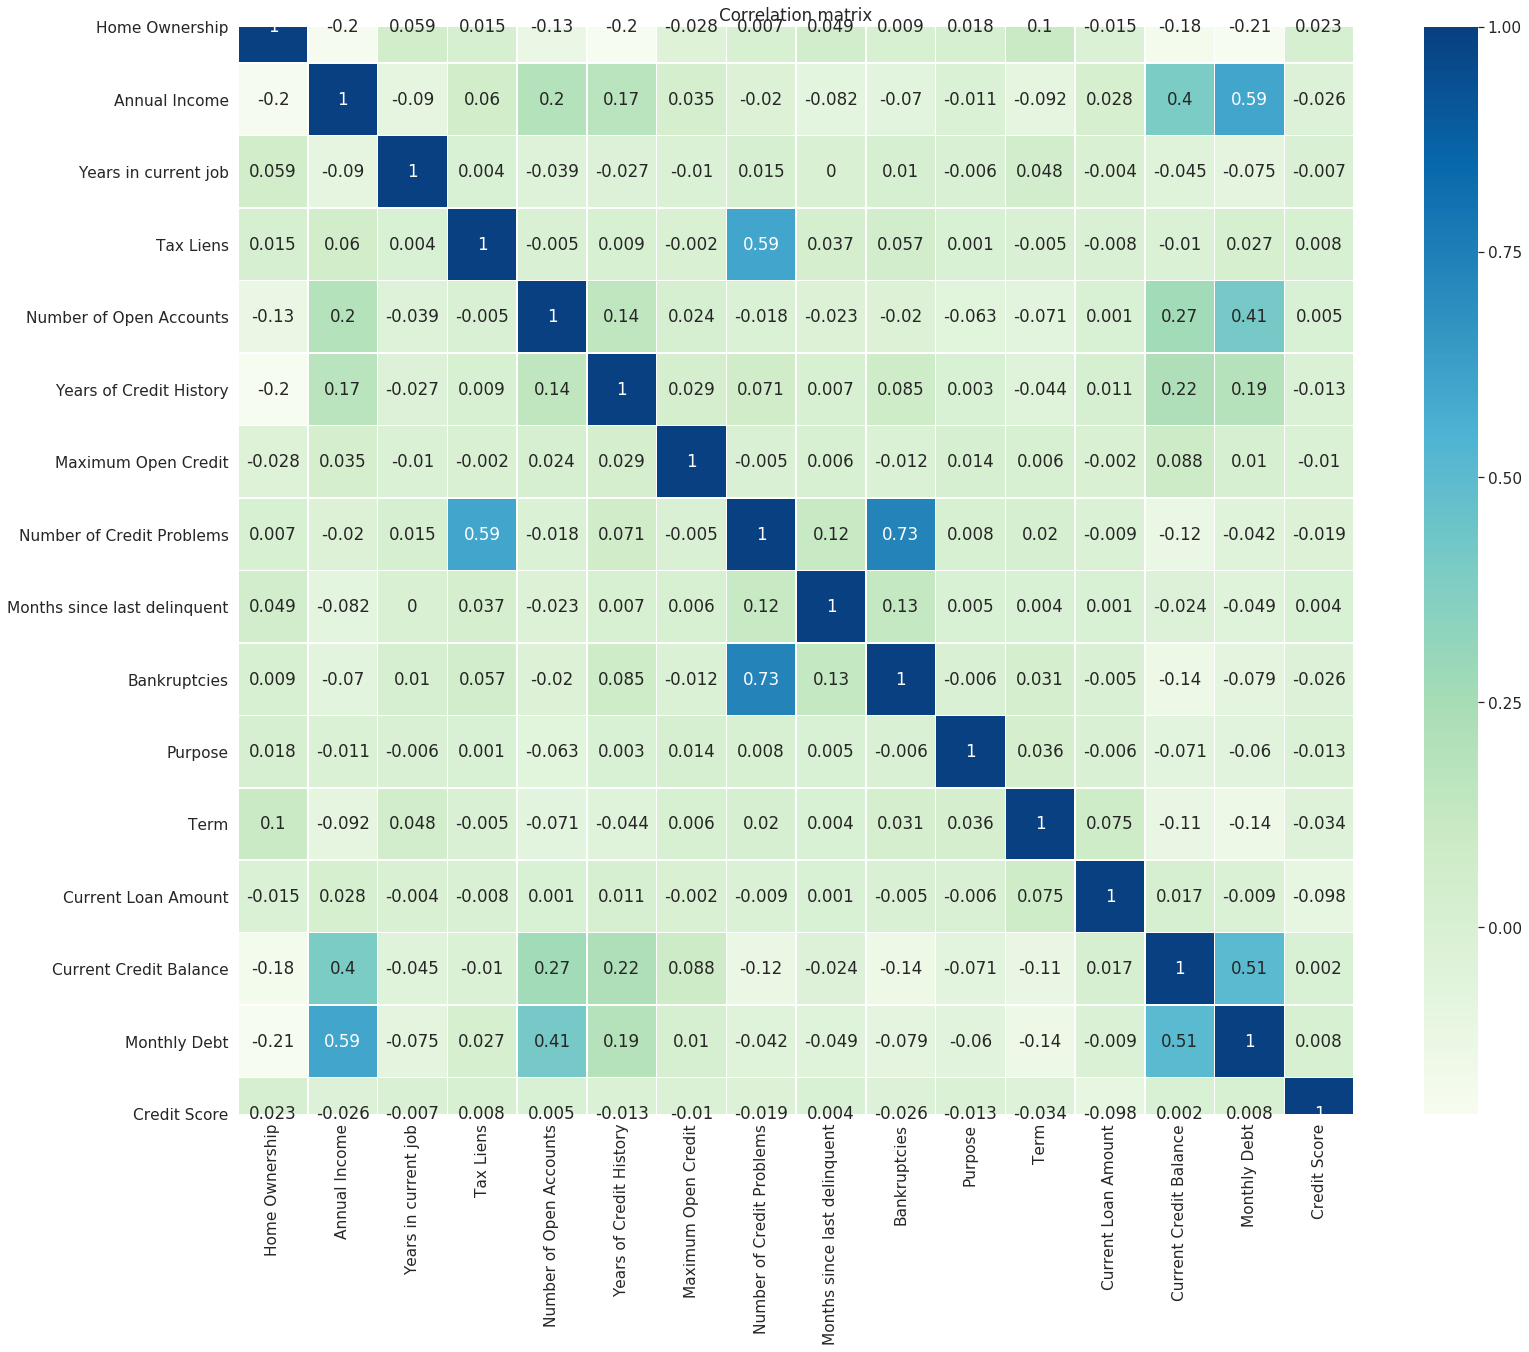

In [90]:
plt.figure(figsize = (25,20))

sns.set(font_scale=1.4)
sns.heatmap(df_train[BASE_FEATURE_NAMES].corr().round(3), annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

**Рассмотрим характер распределения данных по целевому признаку**

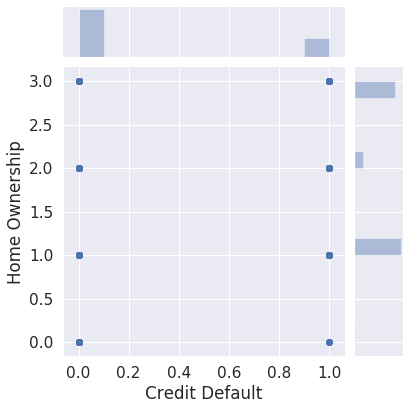

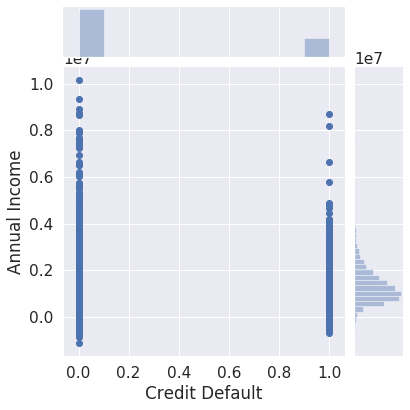

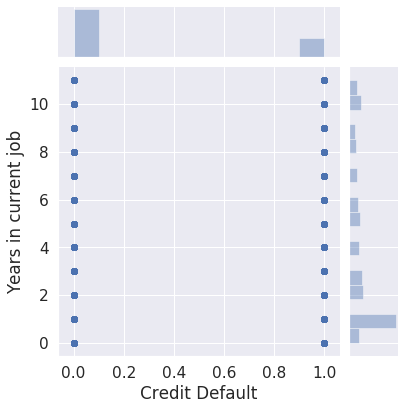

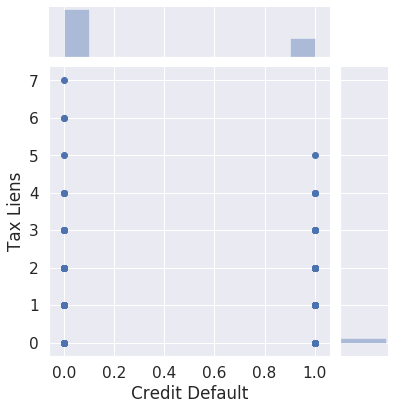

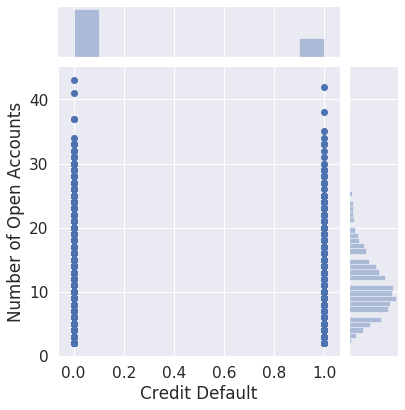

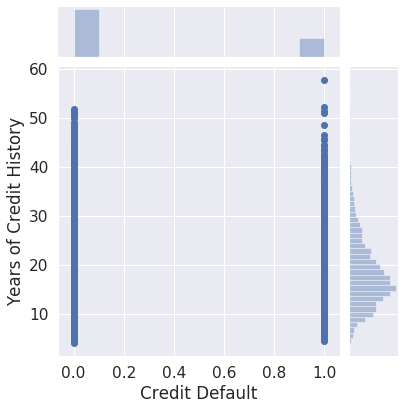

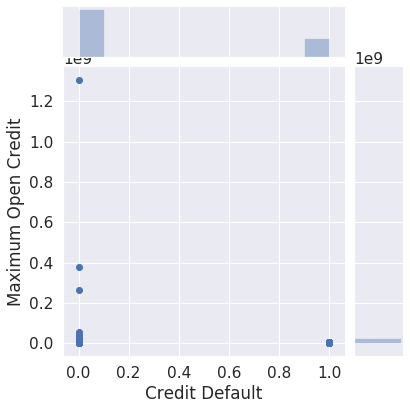

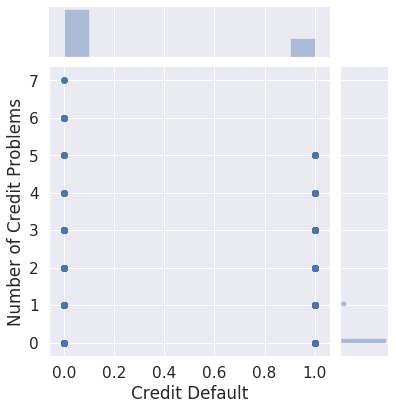

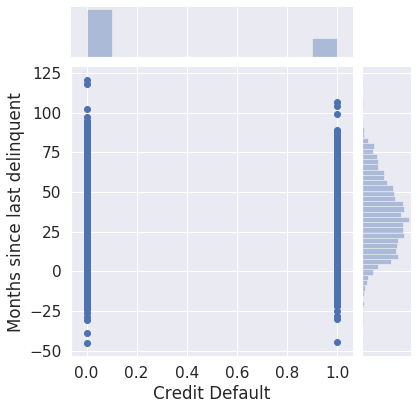

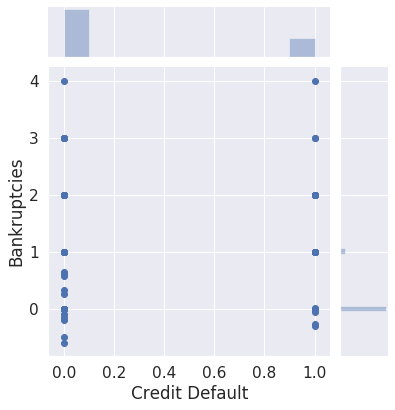

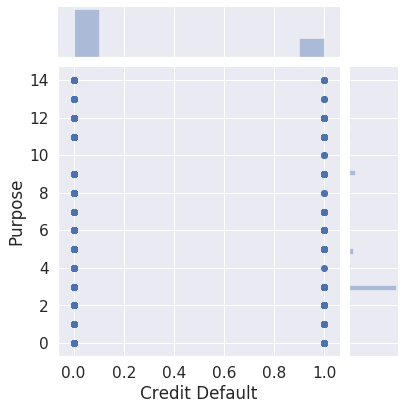

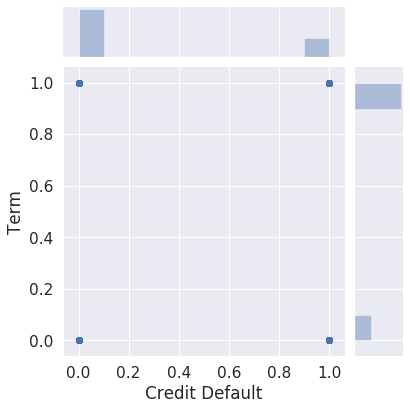

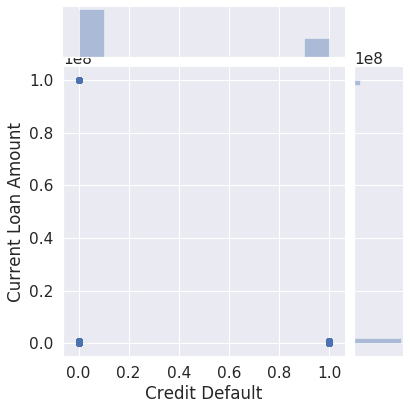

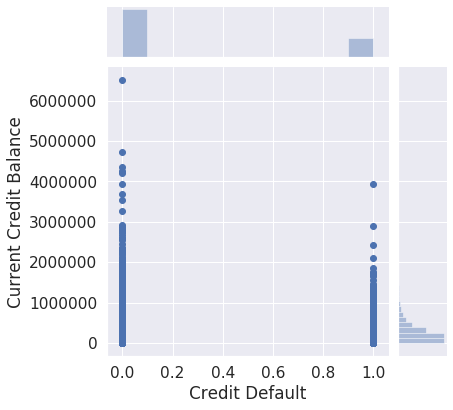

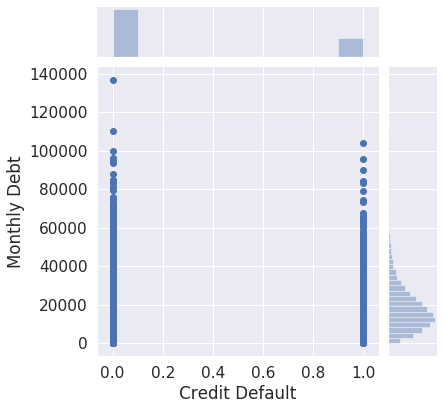

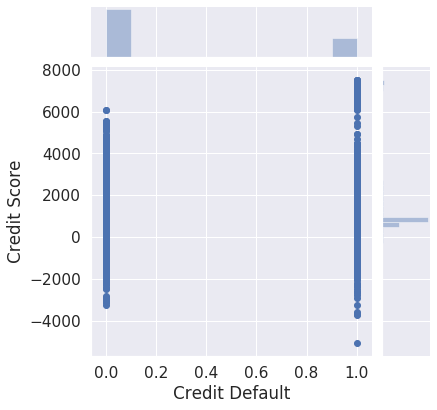

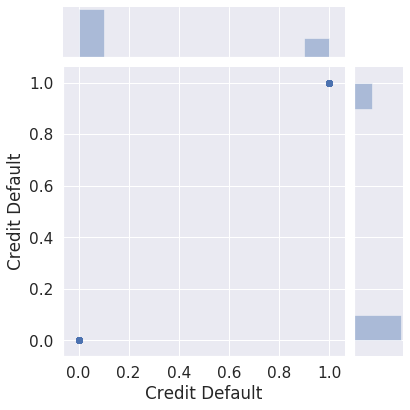

In [91]:
for column in df_train:
    sns.jointplot(y=column, x= 'Credit Default', data=df_train)
    plt.show()


## Подготовка модели<a class="anchor" id="make_model"></a>

In [92]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

In [93]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [94]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

**Предварительный отбор признаков**

In [95]:
FEATS_BASE = ['Home Ownership', 'Annual Income', 'Years in current job', 'Tax Liens',
       'Number of Open Accounts', 'Years of Credit History',
       'Maximum Open Credit', 'Number of Credit Problems',
       'Months since last delinquent', 'Bankruptcies', 'Purpose', 'Term',
       'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt',
       'Credit Score']
TARGET_NAME = ['Credit Default']

In [96]:
X = df_train[FEATS_BASE]
y = df_train[TARGET_NAME]

* Предварительная модель

In [97]:
model= CatBoostClassifier()
model.fit(X, y)

Learning rate set to 0.024355
0:	learn: 0.6819824	total: 9.32ms	remaining: 9.31s
1:	learn: 0.6685523	total: 18.5ms	remaining: 9.25s
2:	learn: 0.6567809	total: 28.2ms	remaining: 9.36s
3:	learn: 0.6459795	total: 37.7ms	remaining: 9.38s
4:	learn: 0.6390133	total: 47.4ms	remaining: 9.43s
5:	learn: 0.6288776	total: 56.5ms	remaining: 9.36s
6:	learn: 0.6216759	total: 66.2ms	remaining: 9.39s
7:	learn: 0.6139734	total: 75.4ms	remaining: 9.36s
8:	learn: 0.6062864	total: 84.9ms	remaining: 9.35s
9:	learn: 0.5982000	total: 92.7ms	remaining: 9.18s
10:	learn: 0.5904322	total: 102ms	remaining: 9.18s
11:	learn: 0.5848824	total: 112ms	remaining: 9.19s
12:	learn: 0.5792802	total: 121ms	remaining: 9.18s
13:	learn: 0.5742003	total: 130ms	remaining: 9.18s
14:	learn: 0.5670337	total: 140ms	remaining: 9.18s
15:	learn: 0.5627105	total: 149ms	remaining: 9.16s
16:	learn: 0.5585041	total: 155ms	remaining: 8.97s
17:	learn: 0.5551144	total: 165ms	remaining: 8.98s
18:	learn: 0.5512837	total: 174ms	remaining: 8.99s
1

162:	learn: 0.4488109	total: 1.65s	remaining: 8.48s
163:	learn: 0.4486166	total: 1.67s	remaining: 8.49s
164:	learn: 0.4484546	total: 1.68s	remaining: 8.48s
165:	learn: 0.4482258	total: 1.69s	remaining: 8.47s
166:	learn: 0.4481227	total: 1.7s	remaining: 8.46s
167:	learn: 0.4479582	total: 1.71s	remaining: 8.45s
168:	learn: 0.4477079	total: 1.72s	remaining: 8.43s
169:	learn: 0.4474857	total: 1.72s	remaining: 8.42s
170:	learn: 0.4472883	total: 1.73s	remaining: 8.41s
171:	learn: 0.4470880	total: 1.74s	remaining: 8.39s
172:	learn: 0.4468606	total: 1.75s	remaining: 8.38s
173:	learn: 0.4466410	total: 1.76s	remaining: 8.37s
174:	learn: 0.4464243	total: 1.77s	remaining: 8.35s
175:	learn: 0.4462513	total: 1.78s	remaining: 8.34s
176:	learn: 0.4460277	total: 1.79s	remaining: 8.33s
177:	learn: 0.4458119	total: 1.8s	remaining: 8.32s
178:	learn: 0.4456412	total: 1.81s	remaining: 8.3s
179:	learn: 0.4455125	total: 1.82s	remaining: 8.29s
180:	learn: 0.4453219	total: 1.83s	remaining: 8.28s
181:	learn: 0.4

327:	learn: 0.4198732	total: 3.3s	remaining: 6.77s
328:	learn: 0.4197119	total: 3.32s	remaining: 6.77s
329:	learn: 0.4195384	total: 3.33s	remaining: 6.76s
330:	learn: 0.4193327	total: 3.34s	remaining: 6.75s
331:	learn: 0.4191664	total: 3.35s	remaining: 6.74s
332:	learn: 0.4190601	total: 3.36s	remaining: 6.73s
333:	learn: 0.4188932	total: 3.37s	remaining: 6.72s
334:	learn: 0.4187081	total: 3.38s	remaining: 6.71s
335:	learn: 0.4185340	total: 3.39s	remaining: 6.7s
336:	learn: 0.4184293	total: 3.4s	remaining: 6.68s
337:	learn: 0.4182437	total: 3.41s	remaining: 6.67s
338:	learn: 0.4180510	total: 3.42s	remaining: 6.66s
339:	learn: 0.4178714	total: 3.43s	remaining: 6.65s
340:	learn: 0.4178053	total: 3.44s	remaining: 6.64s
341:	learn: 0.4176132	total: 3.44s	remaining: 6.63s
342:	learn: 0.4173968	total: 3.46s	remaining: 6.62s
343:	learn: 0.4172044	total: 3.46s	remaining: 6.61s
344:	learn: 0.4170711	total: 3.47s	remaining: 6.59s
345:	learn: 0.4168486	total: 3.48s	remaining: 6.58s
346:	learn: 0.4

495:	learn: 0.3909238	total: 4.98s	remaining: 5.06s
496:	learn: 0.3907685	total: 4.99s	remaining: 5.05s
497:	learn: 0.3905715	total: 5s	remaining: 5.04s
498:	learn: 0.3903658	total: 5.01s	remaining: 5.03s
499:	learn: 0.3901751	total: 5.02s	remaining: 5.02s
500:	learn: 0.3899671	total: 5.03s	remaining: 5.01s
501:	learn: 0.3898339	total: 5.04s	remaining: 5s
502:	learn: 0.3896996	total: 5.05s	remaining: 4.99s
503:	learn: 0.3895683	total: 5.06s	remaining: 4.98s
504:	learn: 0.3894227	total: 5.07s	remaining: 4.97s
505:	learn: 0.3892557	total: 5.08s	remaining: 4.96s
506:	learn: 0.3891085	total: 5.09s	remaining: 4.95s
507:	learn: 0.3889652	total: 5.1s	remaining: 4.94s
508:	learn: 0.3888009	total: 5.11s	remaining: 4.93s
509:	learn: 0.3886757	total: 5.12s	remaining: 4.92s
510:	learn: 0.3884946	total: 5.13s	remaining: 4.91s
511:	learn: 0.3883558	total: 5.13s	remaining: 4.89s
512:	learn: 0.3882203	total: 5.14s	remaining: 4.88s
513:	learn: 0.3880245	total: 5.16s	remaining: 4.88s
514:	learn: 0.38784

663:	learn: 0.3639206	total: 6.68s	remaining: 3.38s
664:	learn: 0.3637726	total: 6.7s	remaining: 3.37s
665:	learn: 0.3636660	total: 6.71s	remaining: 3.36s
666:	learn: 0.3634958	total: 6.72s	remaining: 3.35s
667:	learn: 0.3632491	total: 6.73s	remaining: 3.34s
668:	learn: 0.3631253	total: 6.74s	remaining: 3.33s
669:	learn: 0.3629095	total: 6.75s	remaining: 3.32s
670:	learn: 0.3627446	total: 6.75s	remaining: 3.31s
671:	learn: 0.3626291	total: 6.76s	remaining: 3.3s
672:	learn: 0.3625014	total: 6.77s	remaining: 3.29s
673:	learn: 0.3623925	total: 6.78s	remaining: 3.28s
674:	learn: 0.3622495	total: 6.79s	remaining: 3.27s
675:	learn: 0.3620793	total: 6.8s	remaining: 3.26s
676:	learn: 0.3619166	total: 6.81s	remaining: 3.25s
677:	learn: 0.3617916	total: 6.82s	remaining: 3.24s
678:	learn: 0.3616038	total: 6.83s	remaining: 3.23s
679:	learn: 0.3614693	total: 6.84s	remaining: 3.22s
680:	learn: 0.3612833	total: 6.85s	remaining: 3.21s
681:	learn: 0.3611001	total: 6.86s	remaining: 3.2s
682:	learn: 0.36

830:	learn: 0.3401159	total: 8.4s	remaining: 1.71s
831:	learn: 0.3399785	total: 8.41s	remaining: 1.7s
832:	learn: 0.3398441	total: 8.41s	remaining: 1.69s
833:	learn: 0.3397355	total: 8.43s	remaining: 1.68s
834:	learn: 0.3395775	total: 8.44s	remaining: 1.67s
835:	learn: 0.3394784	total: 8.44s	remaining: 1.66s
836:	learn: 0.3393786	total: 8.45s	remaining: 1.65s
837:	learn: 0.3392413	total: 8.46s	remaining: 1.64s
838:	learn: 0.3391769	total: 8.47s	remaining: 1.63s
839:	learn: 0.3390601	total: 8.48s	remaining: 1.61s
840:	learn: 0.3389460	total: 8.49s	remaining: 1.6s
841:	learn: 0.3387899	total: 8.5s	remaining: 1.59s
842:	learn: 0.3385993	total: 8.51s	remaining: 1.58s
843:	learn: 0.3384829	total: 8.52s	remaining: 1.57s
844:	learn: 0.3382775	total: 8.53s	remaining: 1.56s
845:	learn: 0.3381508	total: 8.54s	remaining: 1.55s
846:	learn: 0.3380566	total: 8.55s	remaining: 1.54s
847:	learn: 0.3378612	total: 8.56s	remaining: 1.53s
848:	learn: 0.3377220	total: 8.57s	remaining: 1.52s
849:	learn: 0.33

996:	learn: 0.3199374	total: 10.1s	remaining: 30.3ms
997:	learn: 0.3197967	total: 10.1s	remaining: 20.2ms
998:	learn: 0.3196566	total: 10.1s	remaining: 10.1ms
999:	learn: 0.3195279	total: 10.1s	remaining: 0us


* Предварительный набор признаков

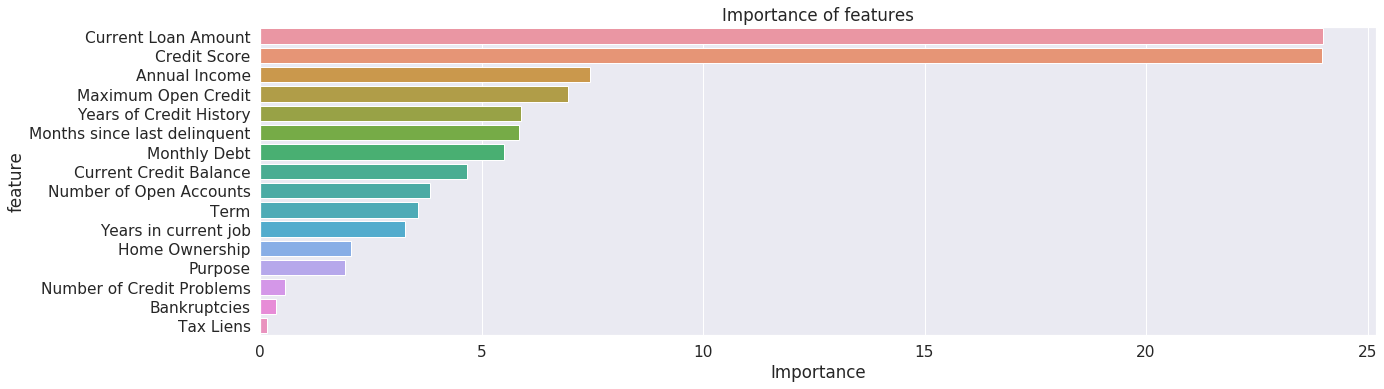

In [98]:
important_features_top = show_feature_importances(X.columns, model.feature_importances_, get_top=15)

* Отобранные признаки для использования

In [99]:

feats = ['Home Ownership', 'Annual Income', 
         'Years in current job',
         'Number of Open Accounts', 
         'Years of Credit History',
         'Maximum Open Credit', 
         'Number of Credit Problems',
         'Purpose', 
         'Term',
         'Current Loan Amount', 
         'Current Credit Balance', 
         'Monthly Debt',
         'Credit Score']
# FEATS_IMP = feats

**Стандартизация данных**

In [100]:
def standart_df(df_train, feats):

    scaler = StandardScaler()

    df_norm = df_train.copy()
    df_norm[feats] = scaler.fit_transform(df_norm[feats])
    data = df_norm.copy()
    
    return data


In [101]:
data=standart_df(df_train, feats)


**Балансировка данных**

In [102]:
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import RandomOverSampler 

In [103]:
def balans_df(X,y):
    '''проводит балансировку данных'''
    
    ros = RandomOverSampler(random_state=42)
    X_resampled, y_resampled = ros.fit_resample(X, y)
    
    print('Resampled dataset shape %s' % Counter(y_resampled))
    return X_resampled, y_resampled

In [104]:
X = data[feats]
y = data['Credit Default']
print('Before sampled dataset shape %s' % Counter(y))

Before sampled dataset shape Counter({0.0: 5387, 1.0: 2113})


In [105]:
# Баланс в целевой переменной после оверсэмплинга
X_resampled,y_resampled = balans_df(X,y)

Resampled dataset shape Counter({0.0: 5387, 1.0: 5387})


**Разбиваем данные для модели**

In [106]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.25, random_state=42)

## Применение модели<a class="anchor" id="practice"></a>

Отбор параметров для модели **model_ctb**:

*params_c = {'n_estimators':randint(0,1000),
          'max_depth':randint(0,100),
           'od_wait' : randint(0,10),
           'best_model_min_trees': randint(0,100),
           'random_state': randint(0,200),
            'loss_function':['Logloss','CrossEntropy'],
             'od_type':['IncToDec','Iter'],
           'l2_leaf_reg':randint(0,100),
            'learning_rate':uniform(loc=0,scale=10)
            'use_best_model':[True,False]
           }
cv=KFold(n_splits=3, random_state=21, shuffle=True)*

производился вот такой моделью:

*rs = RandomizedSearchCV(model_ctb, params_c, scoring='f1', cv=cv, n_jobs=-1)
rs.fit(X_train, y_train)
rs.best_params_,rs.best_score_*

Она затратна по времени, поэтому привожу её в виде комментария.

In [107]:
model_ctb = CatBoostClassifier(best_model_min_trees=35, 
                               l2_leaf_reg=95,
                               loss_function ='Logloss',
                               max_depth= 11, 
                               n_estimators=750,
                               od_wait=2,
                               random_state=162,
                               silent=True,
                               learning_rate=0.02)

model_ctb.fit(X_resampled, y_resampled)


y_train_pred = model_ctb.predict(X_train)
y_test_pred = model_ctb.predict(X_test)
y_test_pred_probs = model_ctb.predict_proba(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

         0.0       0.93      0.89      0.91      4074
         1.0       0.75      0.82      0.78      1551

    accuracy                           0.87      5625
   macro avg       0.84      0.86      0.85      5625
weighted avg       0.88      0.87      0.88      5625

TEST

              precision    recall  f1-score   support

         0.0       0.93      0.89      0.91      1313
         1.0       0.77      0.84      0.80       562

    accuracy                           0.87      1875
   macro avg       0.85      0.86      0.85      1875
weighted avg       0.88      0.87      0.88      1875

CONFUSION MATRIX

col_0            0.0  1.0
Credit Default           
0.0             1169  144
1.0               92  470


* Получена модель со значением F1 > 0.5

In [108]:
y_test_pred_probs = model_ctb.predict_proba(X_test)

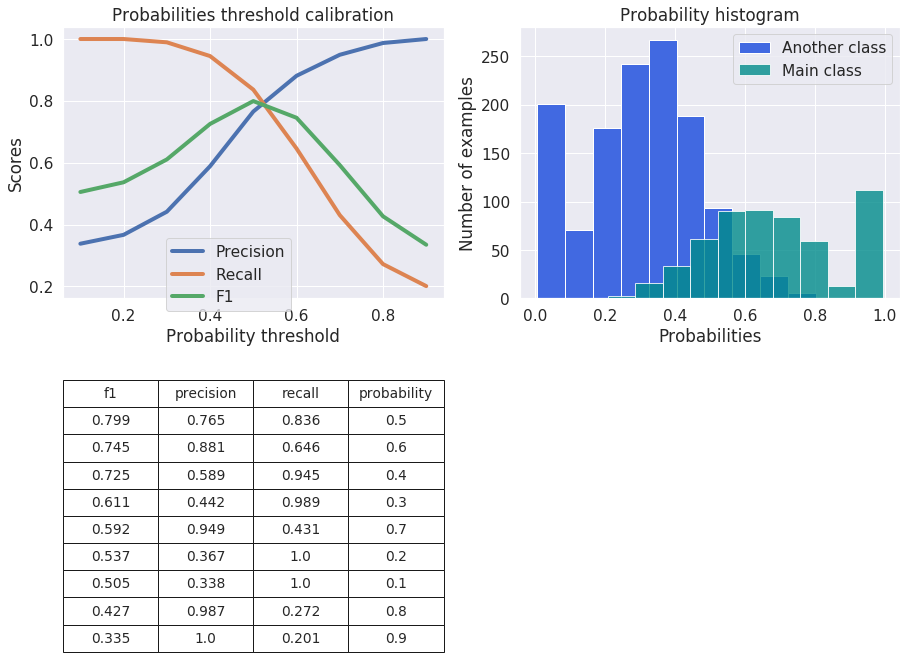

In [109]:
show_proba_calibration_plots(y_test_pred_probs[:, 1], y_test)

**Сохранение модели**

In [110]:
with open(MODEL_FILE_PATH, 'wb') as file:
    pickle.dump(model_ctb, file)

**Работа с тестовыми данными**

In [111]:
test = pd.read_csv(TEST_PATH)

'/usr/local/share/datasets/matrix_sorted.png'

   Home Ownership  Annual Income  Years in current job  Tax Liens  \
0         1.14546      -2.086484              0.007563        0.0   
1         1.14546      -1.248252             -1.174187        0.0   
2        -0.96094      -0.240587             -0.287874        0.0   
3        -0.96094      -0.166413             -0.878749        0.0   
4        -0.96094       1.060073              0.598438        0.0   

   Number of Open Accounts  Years of Credit History  Maximum Open Credit  \
0                -0.450224                -0.803220            -0.323879   
1                -1.068551                 1.981755            -0.433044   
2                -0.244115                -0.637776            -0.334707   
3                 0.992538                -0.182805            -0.168202   
4                -0.038006                 0.727138             0.328576   

   Number of Credit Problems  Months since last delinquent  Bankruptcies  \
0                  -0.289398                     70.

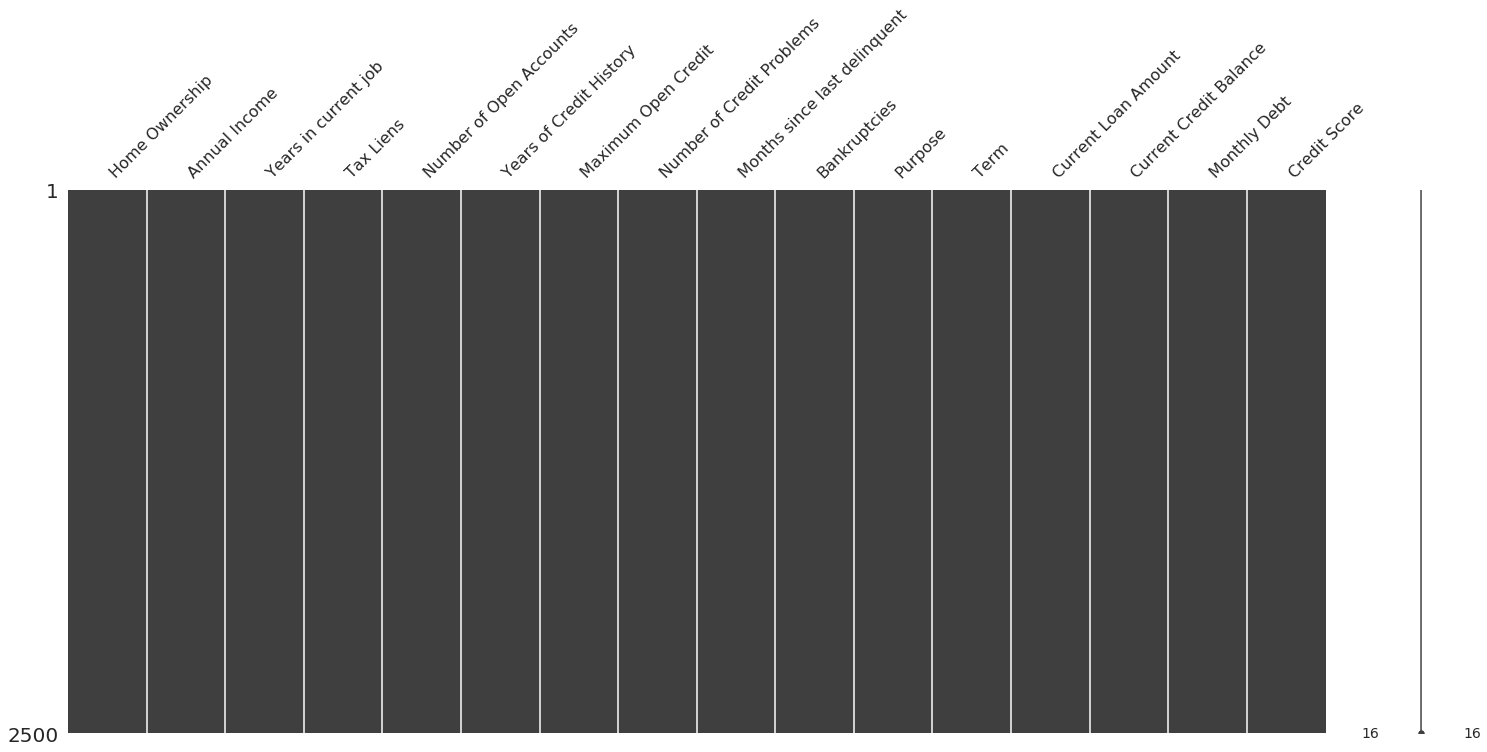

In [112]:
test=prepare_label(test)
test=missing_imputer(test)
test=standart_df(test,feats)
view_matrix(test)

**Финальный датасет**

In [113]:
test['Credit default'] = model_ctb.predict(test.loc[:, feats])

test.loc[:, ['Id', 'Credit default']].to_csv('MTabunov_predictions_210220.csv', index=None)